In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from natsort import natsorted
from skimage.transform import rotate
import pandas as pd
from cellpose_omni import io, transforms
from omnipose.utils import normalize99
from pathlib import Path
import os
from cellpose_omni import io
import omnipose
import pickle
from PIL import Image

2024-04-28 01:03:36,825 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


/home/gh464/miniconda3/envs/omnipose_2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PSFs = ["green", "darkred"]


In [3]:

chans = None

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid

In [60]:
mask_files

['scattered_cells_val_ePSF_darkred/0_masks.png',
 'scattered_cells_val_ePSF_darkred/1_masks.png',
 'scattered_cells_val_ePSF_darkred/2_masks.png',
 'scattered_cells_val_ePSF_darkred/3_masks.png',
 'scattered_cells_val_ePSF_darkred/4_masks.png']

In [64]:
PSFs

['green', 'darkred']

In [61]:
predicted_widths = []
true_widths = []

seg_info = []

for PSF in PSFs:
    files = glob(f"scattered_cells_val_ePSF_{PSF}/*.png")
    img_files = natsorted([file for file in files if "masks.png" not in file])
    mask_files = natsorted([file for file in files if "masks.png" in file])
    
    img = np.array(Image.open(img_files[0]))
    
    
    imgs = [np.array(Image.open(img_file)) for img_file in img_files]
    gts = [np.array(Image.open(gt)) for gt in mask_files]
    for k in range(len(imgs)):
        img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
        if len(img.shape)>2:
            # imgs[k] = img[:,:,1] # could pick out a specific channel
            imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
            
        imgs[k] = normalize99(imgs[k])
        # imgs[k] = np.pad(imgs[k],10,'edge')
    
    chans = None
    
    model_name = glob(f"scattered_cells_ePSF_{PSF}/models/*epoch_3999*")[0]
    
    model = models.CellposeModel(gpu=True, pretrained_model=model_name, nchan=1, nclasses=2,dim=2)
    
    
    # define parameters
    params = {'channels':chans, # always define this with the model
              'rescale': None, # upscale or downscale your images, None = no rescaling 
              'mask_threshold': -1, # erode or dilate masks with higher or lower values 
              'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
              'transparency': True, # transparency in flow output
              'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
              'cluster': True, # use DBSCAN clustering
              'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
              'verbose': False, # turn on if you want to see more output 
              'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
              'niter': 7, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
              'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
              'affinity_seg': False, # new feature, stay tuned...
             }
    
    masks, flows, styles = model.eval([img for img in imgs],**params)
    
    
    for i, mask in enumerate(masks):
        gt = gts[i]
        with open(f'scattered_cells_val_ePSF_{PSF}/{i}.pickle', 'rb') as handle:
            mask_info = pickle.load(handle)
        
        mask_IDs = list(mask_info.keys())
        for mask_ID in mask_IDs:
            seg_label = np.unique((gt == mask_IDs[0]) * mask)[1]
            mask_info[mask_ID]["seg_label"] = seg_label
            a, b = mask_info[mask_ID]["coords_x"]
            c, d = mask_info[mask_ID]["coords_y"]
            a, b, c, d = int(a/3), int(b/3), int(c/3), int(d/3)
            mask_crop = mask[a:b,c:d] > 0
            mask_crop = rotate(mask_crop, -mask_info[mask_ID]["angle"])
            predicted_width = mask_crop[mask_crop.shape[0]//2].sum() * 0.065
            mask_info[mask_ID]["predicted_width"] = predicted_width
            seg_info.append([mask_info[mask_ID]["width"], mask_info[mask_ID]["predicted_width"], PSF])

    #predicted_widths.extend([mask_info[mask_ID]["predicted_width"] for mask_ID in mask_IDs])
    #true_widths.extend([mask_info[mask_ID]["width"] for mask_ID in mask_IDs])

seg_info = pd.DataFrame(seg_info)
seg_info.columns = ["True Width", "Observed Width", "Colour"]

2024-04-30 02:18:16,476 [INFO] ** TORCH GPU version installed and working. **
2024-04-30 02:18:16,477 [INFO] >>>> using GPU
2024-04-30 02:18:18,070 [INFO] 100%|##########| 5/5 [00:01<00:00,  3.22it/s]
2024-04-30 02:18:19,817 [INFO] ** TORCH GPU version installed and working. **
2024-04-30 02:18:19,818 [INFO] >>>> using GPU
2024-04-30 02:18:21,405 [INFO] 100%|##########| 5/5 [00:01<00:00,  3.23it/s]


In [65]:
for i, mask in enumerate(masks):
    Image.fromarray(mask).save(f"scattered_cells_val_ePSF_darkred/{i}_segmented.png")

In [62]:
seg_info.to_pickle("membrane_DL_segmented.pickle")

In [51]:
mask_crop[mask_crop.shape[0]//2].sum()* 0.065

10

In [52]:
import seaborn as sns

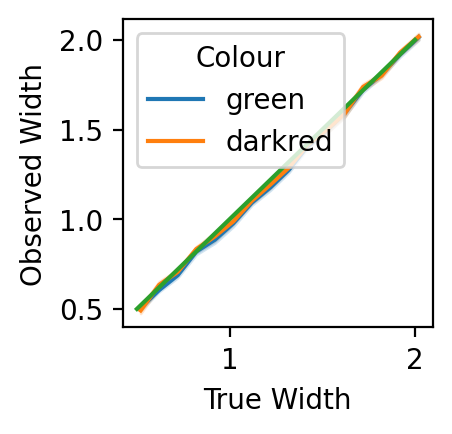

In [53]:
plt.figure(figsize=(2,2), dpi = 200)
sns.lineplot(data = seg_info, x = "True Width", y = "Observed Width", hue = "Colour")
plt.plot([0.5,2],[0.5,2])

In [40]:
len(masks)

5

In [41]:
np.unique((gt == mask_IDs[0]) * mask)

array([ 0, 40], dtype=uint8)

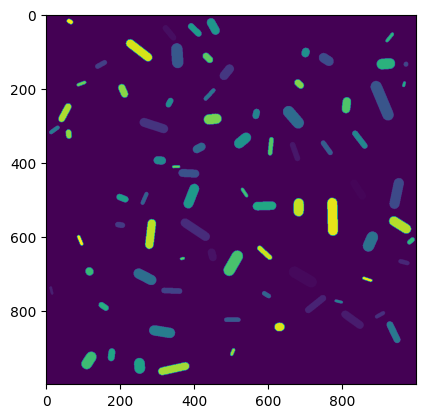

In [35]:
plt.imshow(gt)

In [89]:
img_files

['scattered_cells_for_figure_ePSF_darkred/4.png',
 'scattered_cells_for_figure_ePSF_darkred/4_segmented.png']

In [91]:
predicted_widths = []
true_widths = []

seg_info = []

for PSF in ["darkred"]:
    files = glob(f"scattered_cells_for_figure_ePSF_darkred/*.png")
    img_files = natsorted([file for file in files if "4.png" in file])
    mask_files = natsorted([file for file in files if "4_masks.png" in file])
    
    img = np.array(Image.open(img_files[0]))
    
    
    imgs = [np.array(Image.open(img_file)) for img_file in img_files]
    gts = [np.array(Image.open(gt)) for gt in mask_files]
    for k in range(len(imgs)):
        img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
        if len(img.shape)>2:
            # imgs[k] = img[:,:,1] # could pick out a specific channel
            imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
            
        imgs[k] = normalize99(imgs[k])
        # imgs[k] = np.pad(imgs[k],10,'edge')
    
    chans = None
    
    model_name = glob(f"scattered_cells_ePSF_{PSF}/models/*epoch_3999*")[0]
    
    model = models.CellposeModel(gpu=True, pretrained_model=model_name, nchan=1, nclasses=2,dim=2)
    
    
    # define parameters
    params = {'channels':chans, # always define this with the model
              'rescale': None, # upscale or downscale your images, None = no rescaling 
              'mask_threshold': -1, # erode or dilate masks with higher or lower values 
              'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
              'transparency': True, # transparency in flow output
              'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
              'cluster': True, # use DBSCAN clustering
              'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
              'verbose': False, # turn on if you want to see more output 
              'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
              'niter': 7, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
              'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
              'affinity_seg': False, # new feature, stay tuned...
             }
    
    masks, flows, styles = model.eval([img for img in imgs],**params)
    
    
    for i, mask in enumerate(masks):
        gt = gts[i]
        with open(f'scattered_cells_for_figure_ePSF_darkred/4.pickle', 'rb') as handle:
            mask_info = pickle.load(handle)
        
        mask_IDs = list(mask_info.keys())
        for mask_ID in mask_IDs:
            seg_label = np.unique((gt == mask_IDs[0]) * mask)[1]
            mask_info[mask_ID]["seg_label"] = seg_label
            a, b = mask_info[mask_ID]["coords_x"]
            c, d = mask_info[mask_ID]["coords_y"]
            a, b, c, d = int(a/3), int(b/3), int(c/3), int(d/3)
            mask_crop = mask[a:b,c:d] > 0
            mask_crop = rotate(mask_crop, -mask_info[mask_ID]["angle"])
            predicted_width = mask_crop[mask_crop.shape[0]//2].sum() * 0.065
            mask_info[mask_ID]["predicted_width"] = predicted_width
            seg_info.append([mask_info[mask_ID]["width"], mask_info[mask_ID]["predicted_width"], PSF])

    #predicted_widths.extend([mask_info[mask_ID]["predicted_width"] for mask_ID in mask_IDs])
    #true_widths.extend([mask_info[mask_ID]["width"] for mask_ID in mask_IDs])

seg_info = pd.DataFrame(seg_info)
seg_info.columns = ["True Width", "Observed Width", "Colour"]

2024-04-30 03:52:55,976 [INFO] ** TORCH GPU version installed and working. **
2024-04-30 03:52:55,976 [INFO] >>>> using GPU


In [95]:
with open(f'scattered_cells_for_figure_ePSF_darkred/4.pickle', 'wb') as handle:
    pickle.dump(mask_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

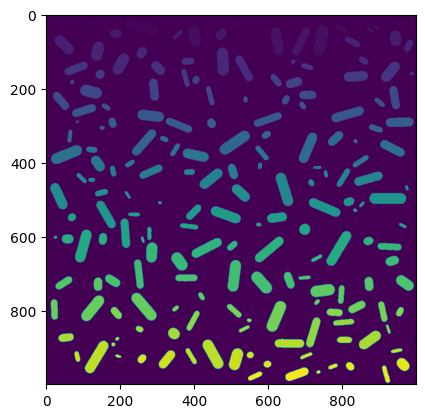

In [72]:
plt.imshow(masks[0])

In [73]:
for i, mask in enumerate(masks):
    Image.fromarray(mask).save(f"scattered_cells_for_figure_ePSF_darkred/4_segmented.png")

In [74]:
mask_info

{1: {'width': 2.0199999999999996,
  'angle': 157.02557175253418,
  'coords_x': [2312, 2592],
  'coords_y': [1773, 1963],
  'seg_label': 149,
  'predicted_width': 1.9500000000000002},
 2: {'width': 1.42,
  'angle': 290.4827303940672,
  'coords_x': [377, 508],
  'coords_y': [140, 349],
  'seg_label': 149,
  'predicted_width': 1.4300000000000002},
 3: {'width': 1.42,
  'angle': 184.13293282788146,
  'coords_x': [1657, 1899],
  'coords_y': [602, 685],
  'seg_label': 149,
  'predicted_width': 1.365},
 4: {'width': 1.42,
  'angle': 116.67763315995413,
  'coords_x': [2313, 2439],
  'coords_y': [2439, 2603],
  'seg_label': 149,
  'predicted_width': 1.365},
 5: {'width': 0.9199999999999999,
  'angle': 123.37639319639831,
  'coords_x': [1136, 1252],
  'coords_y': [2478, 2625],
  'seg_label': 149,
  'predicted_width': 0.845},
 6: {'width': 1.6199999999999997,
  'angle': 151.287160532749,
  'coords_x': [254, 376],
  'coords_y': [720, 832],
  'seg_label': 149,
  'predicted_width': 1.495},
 7: {'wid